<a href="https://colab.research.google.com/github/angellakatusiime/GROUP-7/blob/main/Automated_Detection_of_Sea_Turtle_Facial_Patterns_Using_Bounding_Box_Frameworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated Detection of Sea Turtle Facial Patterns Using Bounding Box Frameworks.



##Group 7
###JONAH MUTYABA
###KUGUMA VICTOR
###KATUSIIME ANGELLA

# Introduction and Libraries Import

Import necessary libraries for image manipulation (PIL), data handling (Pandas), and visualization (Matplotlib).

In [1]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib import pyplot as plt

Mounting my Google Drive with Colab to ease access to the files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Unzipping and Setting the Image Folder
Here, we copy and unzip the folder containing images, setting the path for easy access in subsequent code.

In [3]:
!cp 'drive/My Drive/Turtle_screening/IMAGES_512.zip' .
!unzip -q IMAGES_512.zip
image_folder = 'IMAGES_512'

In [4]:
# Load train and edit path to suit your setup
train = pd.read_csv('drive/My Drive/Turtle_screening/Train.csv')
print(train.shape)
train.head()

(1326, 5)


,Image_ID,x,y,w,h
0,04FB1B33,0.481988,0.506076,0.174696,0.405671
1,B04E481E,0.617405,0.313368,0.177734,0.293113
2,32655645,0.490885,0.465856,0.165582,0.357350
3,44D4DA7C,0.472873,0.506076,0.237847,0.409722
4,4F36EF72,0.433811,0.574363,0.180773,0.397569


# View an Image

Let's check that we have the images where we expect them, and plot a bounding box to visualize our goal here:

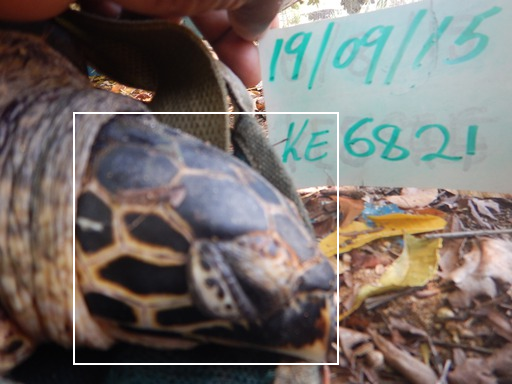

In [5]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Open with PIL and draw a bounding box
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2)
im

# Object Detection

There are many ways to do object detection. Unfortunately, most require quite a bit of code and explanation. Rather than getting bogged down in a complex approach, I'm going to take a somewhat sub-optimal approach for illustrative purposes. The point here is to get a very basic model, so that we can look at evaluation and submissions.

The approach I'll be taking is to frame this as an image regression problem, with the bounding box x, y, w and h as four independant regression outputs.

In [6]:
!pip install --upgrade -q fastcore fastai # Get latest library versions

In [7]:
from fastai.vision.all import *

### Preparing the model
Initialize a data loader using fastai to link images to their bounding box coordinates, specifying the necessary columns and settings for a regression task.

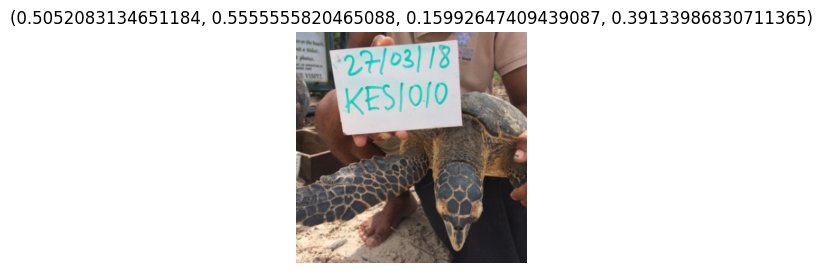

In [8]:
dblock = DataBlock(
  #The DataBlock uses ImageBlock() as an input block (for images) and RegressionBlock(n_out=4)
  #as the target block, n_out=4 indicates that each image has four corresponding numeric outputs: x, y, w, and h.
  blocks=(ImageBlock(), RegressionBlock(n_out=4)),

  #loads each image by its ID, appending the path and file extension to get the full file path.
  getters=[ColReader('Image_ID', pref=f'{image_folder}/', suff='.JPG'),   # image input

           #extracts the bounding box coordinates as the four numeric outputs for each image
           ColReader(['x', 'y', 'w', 'h'])],

  #randomly splits the dataset into training and validation sets for model evaluation.
  splitter=RandomSplitter(),

  #resizes all images to 256x256 pixels, ensuring uniform input dimensions.
  item_tfms = [Resize(256)],
  batch_tfms=None,
  n_inp = 1
)

# Create the dataloaders
dls = dblock.dataloaders(train, bs=64)

#resizes all images to 256x256 pixels, ensuring uniform input dimensions.
dls.show_batch(max_n=1)


In [9]:
import os
import pandas as pd
import numpy as np

# Specify the path to your image folder
#image_folder = 'path_to_your_image_folder'  # Replace with your actual path

# List all files in the image folder with .JPG extension
image_ids = [f.split('.')[0] for f in os.listdir(image_folder) if f.endswith('.JPG')]

# Create sample output data using the image IDs without the .JPG suffix
sample_output_data = {
    "Image_ID": image_ids,  # Image IDs without the .JPG suffix
    "x": np.round(np.random.rand(len(image_ids)), 2),  # Random values for x
    "y": np.round(np.random.rand(len(image_ids)), 2),  # Random values for y
    "w": np.round(np.random.rand(len(image_ids)), 2),  # Random values for w
    "h": np.round(np.random.rand(len(image_ids)), 2)   # Random values for h
}

# Creating the DataFrame
sample_output_df = pd.DataFrame(sample_output_data)

# Display the DataFrame
print(sample_output_df)

      Image_ID     x     y     w     h
0     714967A4  0.75  0.75  0.68  0.54
1     5C8D4687  0.15  0.79  0.90  0.11
2     CB43C2D3  0.69  0.69  0.22  0.40
3     69C58A4A  0.97  0.34  0.63  0.00
4     EF2249DB  0.64  0.51  0.70  0.36
...        ...   ...   ...   ...   ...
2018  30225D43  0.40  0.56  0.10  0.73
2019  AEBEA960  0.52  0.76  0.52  0.42
2020  9E202064  0.05  0.41  0.14  0.33
2021  85842117  0.52  0.60  0.50  0.30
2022  92D823B0  0.30  0.58  0.62  0.96

[2023 rows x 5 columns]


### Create and train the leaner
Create a convolutional neural network model using the ResNet34 architecture, with specific settings for predicting bounding box coordinates. It uses Mean Squared Error (MSE) as the loss function for regression, normalizes output values to stay between 0 and 1, and outputs 4 values (x, y, w, h) to represent bounding box coordinates.

In [10]:
# We specify n_out and y_range, and pick a loss function.
learn = cnn_learner(dls, resnet34, n_out=4, y_range=(0, 1),
                    loss_func=MSELossFlat(reduction='mean'))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 116MB/s]


###Training the model
The model undergoes fine-tuning for one epoch, initially training only the last layers and then adjusting the entire network to improve performance.

In [11]:
# The model is trained for 1 epoch.
learn.fine_tune(1)

epoch,train_loss,valid_loss,time
0,0.118085,0.079834,08:55


epoch,train_loss,valid_loss,time
0,0.096468,0.047339,12:25


In [12]:
# The
def iou(boxA, boxB):
  # boxA is actually the predictions - a list of [[x, y, w, h], ...]
  # boxB is the targets, same format

  # determine the (x, y)-coordinates of the intersection rectangle
  xA = torch.max(boxA[:,0], boxB[:,0]) # box[:,0] => x
  yA = torch.max(boxA[:,1], boxB[:,1]) # box[:,1] => y
  xB = torch.min(boxA[:,0] + boxA[:,2], boxB[:,0] + boxB[:,2]) # box[:,0] + box[:,2] => x+w
  yB = torch.min(boxA[:,1] + boxA[:,3], boxB[:,1] + boxB[:,3]) # y+h

  eps = 1e-5 # To avoid division by 0

  # area of intersection
  interArea = torch.clamp((xB - xA + eps), 0, 1) * torch.clamp((yB - yA + eps), 0, 1)

  # compute the area of both rectangles

  boxAArea = (boxA[:,2] + eps) * (boxA[:,3] + eps) # w*h
  boxBArea = (boxB[:,2] + eps) * (boxB[:,3] + eps) # w*h

  # IOU
  iou = interArea / (boxAArea + boxBArea - interArea)

  return iou.mean() # Average IOU over all items in batch

In [13]:
learn = cnn_learner(dls, resnet34, n_out=4, y_range=(0, 1),
                    loss_func=MSELossFlat(reduction='mean'),
                    metrics=iou)

###Displaying Training Results
After training, it shows a table with training and validation loss, indicating how well the model has learned and its ability to generalize to new data.

In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,iou,time
0,0.066049,0.029465,0.172050,09:09


epoch,train_loss,valid_loss,iou,time


### View some examples of the model predictions

Here we pull a random image from the training set and overlay the prediction with the actual bounding box.

In [ ]:
# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Get predictions
xp, yp, wp, hp = learn.predict(f'{image_folder}/{imid}.JPG')[0]

# View
with Image.open(f'{image_folder}/{imid}.JPG') as im:
  imw, imh = im.size # Box coords are relative to image size
  draw = ImageDraw.Draw(im)
  draw.rectangle([int(x*imw), int(y*imh), int((x+w)*imw), int((y+h)*imh)], width=2) # Actual
  draw.rectangle([int(xp*imw), int(yp*imh), int((xp+w)*imw), int((yp+h)*imh)], width=2, outline='red') # Pred
im

In [ ]:
from PIL import Image, ImageDraw
import numpy as np

# Take a sample row
imid, x, y, w, h = train.sample().values[0]

# Get predictions
xp, yp, wp, hp = learn.predict(f'{image_folder}/{imid}.JPG')[0]

# Open the image
with Image.open(f'{image_folder}/{imid}.JPG') as im:
    imw, imh = im.size  # Image dimensions

    # Define coordinates for actual and predicted rectangles
    actual_box = [
        (int(x * imw), int(y * imh)),
        (int((x + w) * imw), int((y + h) * imh))
    ]
    pred_box = [
        (int(xp * imw), int(yp * imh)),
        (int((xp + wp) * imw), int((yp + hp) * imh))
    ]

    # Calculate areas
    def area(box):
        """Calculate area of the rectangle given two opposite corners."""
        (x1, y1), (x2, y2) = box
        return abs((x2 - x1) * (y2 - y1))

    area_white = area(actual_box)
    area_red = area(pred_box)

    # Calculate intersection area
    def intersection_area(box1, box2):
        """Calculate intersection area between two boxes."""
        (x1_min, y1_min), (x1_max, y1_max) = box1
        (x2_min, y2_min), (x2_max, y2_max) = box2

        # Determine the overlap area boundaries
        x_overlap = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
        y_overlap = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))

        return x_overlap * y_overlap

    area_intersection = intersection_area(actual_box, pred_box)

    # Calculate IoU
    iou = area_intersection / (area_white + area_red - area_intersection)
    print(f"IoU (Intersection over Union) between actual and predicted boxes: {iou}")

    # Visualization
    draw = ImageDraw.Draw(im)
    draw.rectangle(actual_box, width=2)  # Draw actual box
    draw.rectangle(pred_box, width=2, outline='red')  # Draw predicted box
    im.show()

# Saving Predictions

In [ ]:
# Load sample submission
Sample = pd.read_csv('drive/My Drive/Turtle_screening/Sample.csv')
Sample.head(2)

In [ ]:
# Takes a test dataset and feeds it through the trained model to obtain predictions, which are stored in preds
tdl = dls.test_dl(Sample)
preds =learn.get_preds(dl=tdl)

In [ ]:
print(preds)

In [ ]:
# Updating the columns with the predictions
Sample.loc[:,['x', 'y', 'w', 'h']] = preds[0].numpy()
Sample.head()

In [ ]:
import pandas as pd
import numpy as np

# Assuming sample_output_df and ss DataFrames are already created and ss has been updated with predictions

# Merge the data on Image_ID to align the original values and predictions
comparison_df = pd.merge(sample_output_df, ss[['Image_ID', 'x', 'y', 'w', 'h']], on='Image_ID', suffixes=('_original', '_predicted'))

# Calculate the absolute difference for each feature (x, y, w, h)
comparison_df['x_abs_diff'] = abs(comparison_df['x_original'] - comparison_df['x_predicted'])
comparison_df['y_abs_diff'] = abs(comparison_df['y_original'] - comparison_df['y_predicted'])
comparison_df['w_abs_diff'] = abs(comparison_df['w_original'] - comparison_df['w_predicted'])
comparison_df['h_abs_diff'] = abs(comparison_df['h_original'] - comparison_df['h_predicted'])

# Calculate the variance of absolute differences for each feature
x_abs_variance = comparison_df['x_abs_diff'].var()
y_abs_variance = comparison_df['y_abs_diff'].var()
w_abs_variance = comparison_df['w_abs_diff'].var()
h_abs_variance = comparison_df['h_abs_diff'].var()

# Calculate the overall absolute variance by taking the mean of these variances
overall_absolute_variance = np.mean([x_abs_variance, y_abs_variance, w_abs_variance, h_abs_variance])

print("Overall Absolute Variance across all features:", overall_absolute_variance*100)

In [ ]:
# Save for submission
Sample.to_csv('Submission2.csv', index=False)